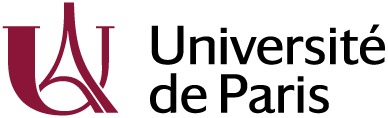
## M2 VMI - TP AD: Object detection using CNNs - Facemasks

Sylvain Lobry, 2020

Pre-requisite: having a google account (sorry about that...)

In this lab we are going to train a model to detect if people are (correctly) wearing face masks. As data, we will use [one of the datasets available on Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection).

## 1) Loading the data
You can get the data [from kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) directly, or through my [Google Drive](https://drive.google.com/drive/folders/1oxP0ept0pmOgjl1BbYaUj9Cf_X7FnI2A?usp=sharing). Then, copy it to your drive.

Now, you need to mount your drive in this VM. This is done by executing the following two lines. You will need to authorize google collab to access to your drive (it will ask you to open a link and give you a confirmation code that you will have to copy on the text field bellow).

Now find the path to your data:

In [2]:
data_folder = '.\\dataset' #Change this path!!
root_folder = '.'#Change this path!!

## 2) Understanding the data format
In the data folder, you have 2 sub-folders:


1.   images
2.   annotations

The images are in the png format, and the annotations are in the xml format.

**Question 1:** Open an xml file, and try to understand the information it contains and describe it. From this xml, can you guess what bounding box format is used in this dataset?

Let's parse one XML:

In [3]:
import os
import xml.etree.ElementTree as ET

def get_objects(xml_file):
  annotation = ET.parse(xml_file)
  root = annotation.getroot()

  objects = []
  for obj in root.findall('object'):
    new_object = {'name': obj.find('name').text}
    bbox_tree = obj.find('bndbox')
    new_object['bbox'] = [int(bbox_tree.find('xmin').text),
                          int(bbox_tree.find('ymin').text),
                          int(bbox_tree.find('xmax').text),
                          int(bbox_tree.find('ymax').text)]
    objects.append(new_object)
  return objects

and show the bounding boxes on one image:

[{'name': 'without_mask', 'bbox': [79, 105, 109, 142]}, {'name': 'with_mask', 'bbox': [185, 100, 226, 144]}, {'name': 'without_mask', 'bbox': [325, 90, 360, 141]}]


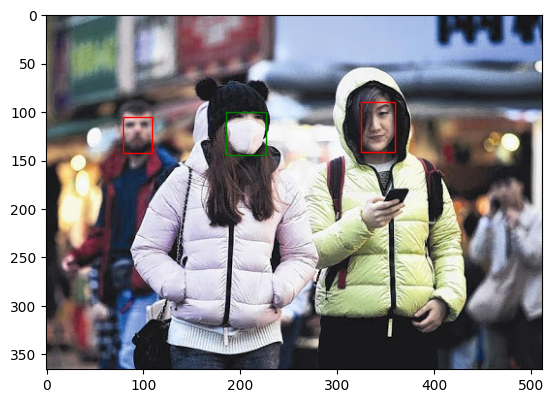

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Color of the bounding boxes (depending on the class)
classes_color = {'with_mask':'g', 'without_mask':'r', 'mask_weared_incorrect':'tab:orange'}
classes_index = {'with_mask':1, 'without_mask':2, 'mask_weared_incorrect':3} #Careful!! 0 is for background!!

def show_bboxes(image, objects):
  fig,ax = plt.subplots(1)
  ax.imshow(image)

  for annotation in objects:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor=classes_color[annotation['name']], facecolor='none')
    ax.add_patch(rect)
  plt.show()

index = 0
objects = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
print(objects)
image = plt.imread(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png'))
show_bboxes(image, objects)

**Question 2:** We are going to learn from this data. By looking at it, can you find possible biases in it?

In [5]:
# Count the number of occurences for each label in the whole dataset
occurences = {'with_mask':0,
              'without_mask':0,
              'mask_weared_incorrect':0}
for index in range(853):
    objects = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
    for object in objects:
        occurences[object['name']] += 1

print(occurences)

{'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123}


## 3) Creating the dataset class

Now, we need to create a class derived from pytorch's Dataset class able to understand or data format. Since the datasert is not too big, we can load it entirely in RAM.

In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image

class FaceMaskDataset(Dataset):
  def __init__(self, img_folder, annotation_folder, indexes, conversion=T.ToTensor()):
    self.conversion = conversion
    
    self.dataset = []
    for index in tqdm(indexes):
      sample = {}
      sample['image'] = Image.open(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png')).convert('RGB')
      sample['objects'] = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
      sample['id'] = index
      self.dataset.append(sample)
    
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    target = {'boxes': [], 'labels': []}
    for obj in self.dataset[idx]['objects']:
      target["boxes"].append(obj['bbox'])
      target['labels'].append(classes_index[obj['name']])
      
    target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float32)
    target["labels"] = torch.as_tensor(target['labels'], dtype=torch.int64)
    target["image_id"] = torch.tensor([self.dataset[idx]['id']])

    img = self.dataset[idx]['image']
    if self.conversion is not None:
      img = self.conversion(img)
    return img, target

And we can create the datasets.

**Question 3:** What is the total number of samples that we have? Does that seem sufficient to train a model? What strategy could we use for training? 

In [7]:
import random
import torch

train_split_percentage = 0.8
val_split_percentage = 0.1
test_split_percentage = 0.1
size_of_the_dataset = 853 #We have 853 images in the dataset

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)

train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes)):int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int((train_split_percentage + val_split_percentage)*len(indexes)):]

print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%", flush=True)

# From https://github.com/pytorch/vision/blob/ce342580f3ae3f937fa5389c48b82a827b4804df/references/detection/utils.py#L235
def collate_fn(batch):
    return tuple(zip(*batch))



def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    #TODO: potentially add data augmentation
    return T.Compose(transforms)

batch_size = 2
print(f"Loading training set from {os.path.join(data_folder, 'images')}")
train_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), train_indexes, conversion=get_transform(True))
print(f"Loading validation set from {os.path.join(data_folder, 'images')}")
val_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), val_indexes, conversion=get_transform(False))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

Effective train split = 79.95310668229777%
Effective val split = 9.964830011723329%
Effective test split = 10.082063305978899%
Loading training set from .\dataset\images


100%|██████████| 682/682 [00:05<00:00, 114.92it/s]


Loading validation set from .\dataset\images


100%|██████████| 85/85 [00:00<00:00, 109.86it/s]


One thing which is always important is to check the data. At the sample size, we have already seen how to check that we understood the data format, and checked a few samples for corectness. At a larger scale, it is often a good idea to check the labels' distribution.

**Question 4:** Propose and implement a methodology to check the labels' distribution. Discuss your findings.

## 4) Defining the model

For this project, we propose to take a pre-trained Faster R-CNN.

Faster R-CNN is an extension of R-CNN seen during the lecture. Conceptually, both methods are very similar. The main improvements of Faster R-CNN is to share convolutional features between the region proposal part and the actual object detection part. To know more, you can read [the original article](https://arxiv.org/pdf/1506.01497.pdf).

This network has been pre-trained on [MS-COCO](https://cocodataset.org/#home), which is a classical large-scale object detection dataset.


In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4 #(3 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\paris_cite\m2\cours\analyse d'image\TP\TP3\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\paris_cite\m2\cours\analyse d'image\TP\TP3\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 5) Training

Now that we have both the architecture and the data, we can train our model.

You should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = model.to(device)

Using device: cuda


We can now define the training loop.

**Question 5:** How did you choose your hyper-parameters?

Starting epoch 0


100%|██████████| 43/43 [00:08<00:00,  5.27it/s]


Starting epoch 1


100%|██████████| 43/43 [00:08<00:00,  5.20it/s]


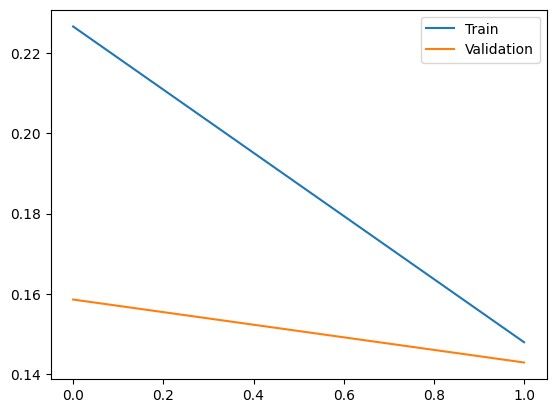

Starting epoch 2


100%|██████████| 43/43 [00:08<00:00,  5.10it/s]


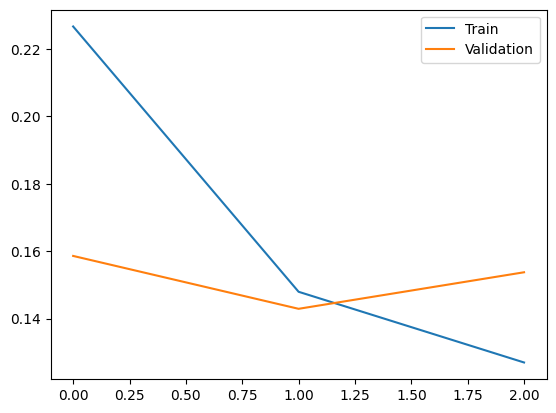

Starting epoch 3


100%|██████████| 43/43 [00:08<00:00,  5.31it/s]


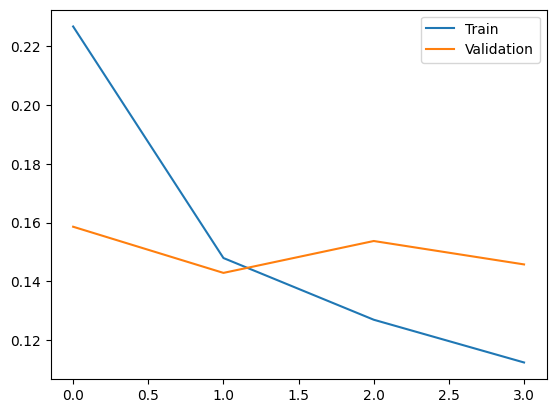

Starting epoch 4


100%|██████████| 43/43 [00:08<00:00,  5.26it/s]


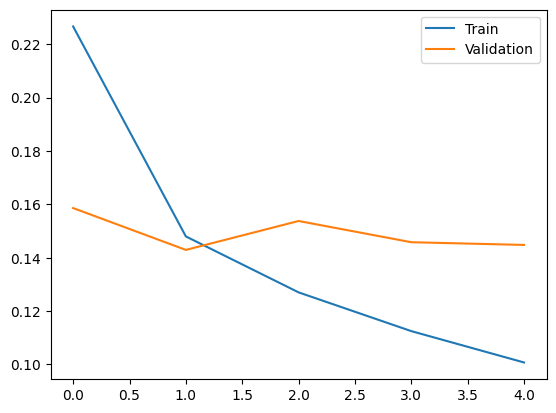

Starting epoch 5


100%|██████████| 43/43 [00:09<00:00,  4.56it/s]


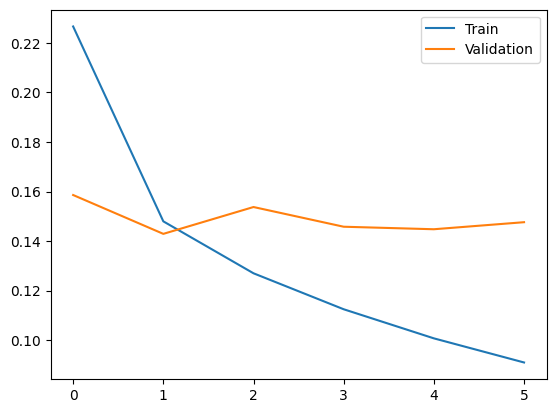

Starting epoch 6


100%|██████████| 43/43 [00:09<00:00,  4.57it/s]


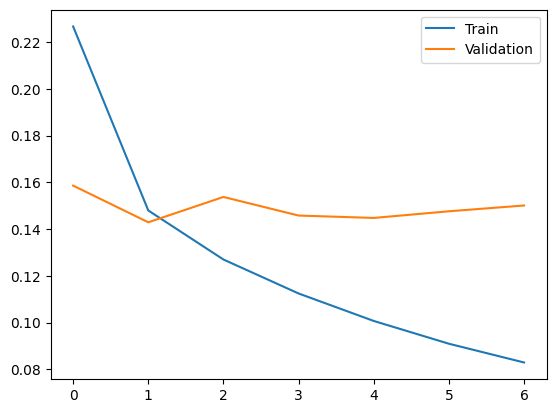

Starting epoch 7


100%|██████████| 43/43 [00:09<00:00,  4.61it/s]


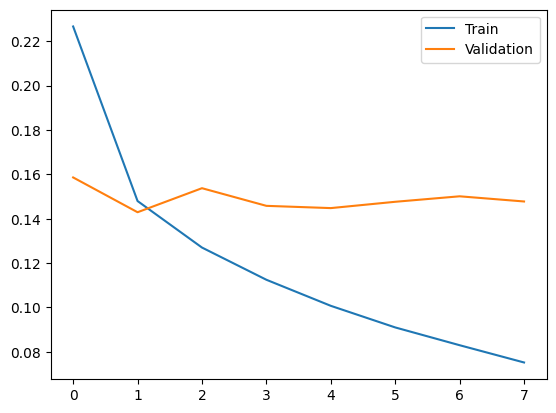

Starting epoch 8


100%|██████████| 43/43 [00:09<00:00,  4.60it/s]


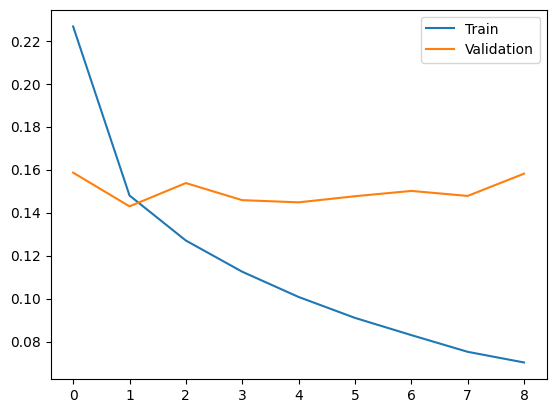

Starting epoch 9


100%|██████████| 43/43 [00:09<00:00,  4.67it/s]


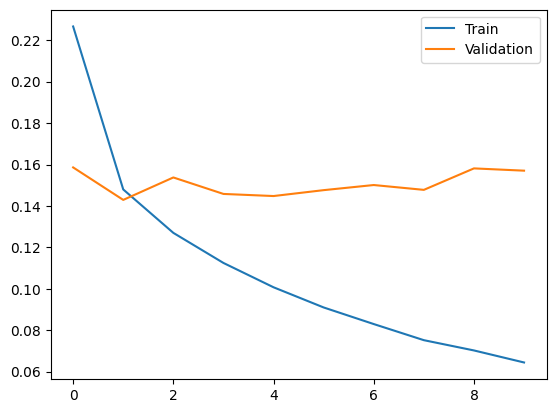

In [9]:
number_epochs = 10 #TODO: Choose
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9) #TODO : choose learning rate and momentum (used default values https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

train_loss = []
val_loss = []

for epoch in range(number_epochs):
  print(f"Starting epoch {epoch}")

  if epoch > 0:
    plt.figure()

  model.train()
  train_loss.append(0)
  for images, labels in tqdm(train_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

    loss_dict = model(images, labels)

    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step() 

    train_loss[epoch] += losses.cpu().data
  train_loss[epoch] /= len(train_dataset)

  if epoch > 0:
    train_plt, = plt.plot(train_loss, label = 'Train')

  val_loss.append(0)
  with torch.no_grad():
    for images, labels in tqdm(val_loader):
      images = list(image.to(device) for image in images)
      labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

      loss_dict = model(images, labels)

      losses = sum(loss for loss in loss_dict.values())

      val_loss[epoch] += losses.cpu().data
    val_loss[epoch] /= len(val_dataset)

  if epoch > 0:
    val_plt, = plt.plot(val_loss, label = 'Validation')
    plt.legend(handles=[train_plt, val_plt])
    plt.show()

  torch.save(model.state_dict(), os.path.join(root_folder, 'model_epoch' + str(epoch) + '.pt'))

## 6) Evaluate the model
First, we need to load the test set:

In [13]:
print("Loading test set")
test_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), test_indexes, conversion=get_transform(False))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)


Loading test set


100%|██████████| 86/86 [00:00<00:00, 108.00it/s]


**TODO** Now you need to re-use what you have seen before to do the evaluation (both with losses and classical metrics). You need to discuss it.

Good luck!

In [19]:
# Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4 #(3 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Load the saved state dictionary into the model
model.load_state_dict(torch.load('model_epoch9.pt'))
model = model.to(device)

c:\paris_cite\m2\cours\analyse d'image\TP\TP3\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\paris_cite\m2\cours\analyse d'image\TP\TP3\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Yanis\AppData\Local\Temp\ipykernel_11204\83721341.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, t

In [21]:
test_loss = 0

#model.eval()
for images, labels in tqdm(test_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

    loss_dict = model(images, labels)

    losses = sum(loss for loss in loss_dict.values())

    test_loss += losses.cpu().data
test_loss /= len(test_dataset)

print(test_loss)

100%|██████████| 43/43 [00:08<00:00,  5.21it/s]

tensor(0.0841)
